In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from datetime import datetime
import math
import calendar
import datetime as dt

In [159]:
# Load the data
file_path = 'historical_data.csv'
dash = pd.read_csv(file_path)

# Basic data overview
dash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [160]:
# Converting 'created_at' and 'actual_delivery_time' to datetime objects
dash['created_at'] = pd.to_datetime(dash['created_at'])
dash['actual_delivery_time'] = pd.to_datetime(dash['actual_delivery_time'])

# Calculating delivery time in seconds and creating a new column for it
dash['delivery_time'] = (dash['actual_delivery_time'] - dash['created_at']).dt.total_seconds()

# Displaying the first few rows of the modified dataframe
dash.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [161]:
# Analyzing the 'store_primary_category' distribution
category_counts = data['store_primary_category'].value_counts()

# Display the top 10 categories
top_categories = category_counts.head(10)

# Conducting a correlation analysis of numeric features
numeric_features = data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_features.corr()

top_categories, correlation_matrix


(store_primary_category
 american    24159
 pizza       17321
 mexican     17099
 burger      10958
 sandwich    10060
 chinese      9421
 japanese     9196
 dessert      8773
 fast         7372
 indian       7314
 Name: count, dtype: int64,
                                               market_id  store_id  \
 market_id                                      1.000000  0.017256   
 store_id                                       0.017256  1.000000   
 order_protocol                                -0.021827  0.019527   
 total_items                                   -0.006840 -0.008796   
 subtotal                                      -0.016197 -0.013370   
 num_distinct_items                             0.002551 -0.012727   
 min_item_price                                -0.000152 -0.009128   
 max_item_price                                -0.004913 -0.018661   
 total_onshift_dashers                          0.025564 -0.020606   
 total_busy_dashers                             0.015746 -

(market_id                                         987
 created_at                                          0
 actual_delivery_time                                7
 store_id                                            0
 store_primary_category                           4760
 order_protocol                                    995
 total_items                                         0
 subtotal                                            0
 num_distinct_items                                  0
 min_item_price                                      0
 max_item_price                                      0
 total_onshift_dashers                           16262
 total_busy_dashers                              16262
 total_outstanding_orders                        16262
 estimated_order_place_duration                      0
 estimated_store_to_consumer_driving_duration      526
 delivery_time                                       7
 dtype: int64,
 market_id                                       0

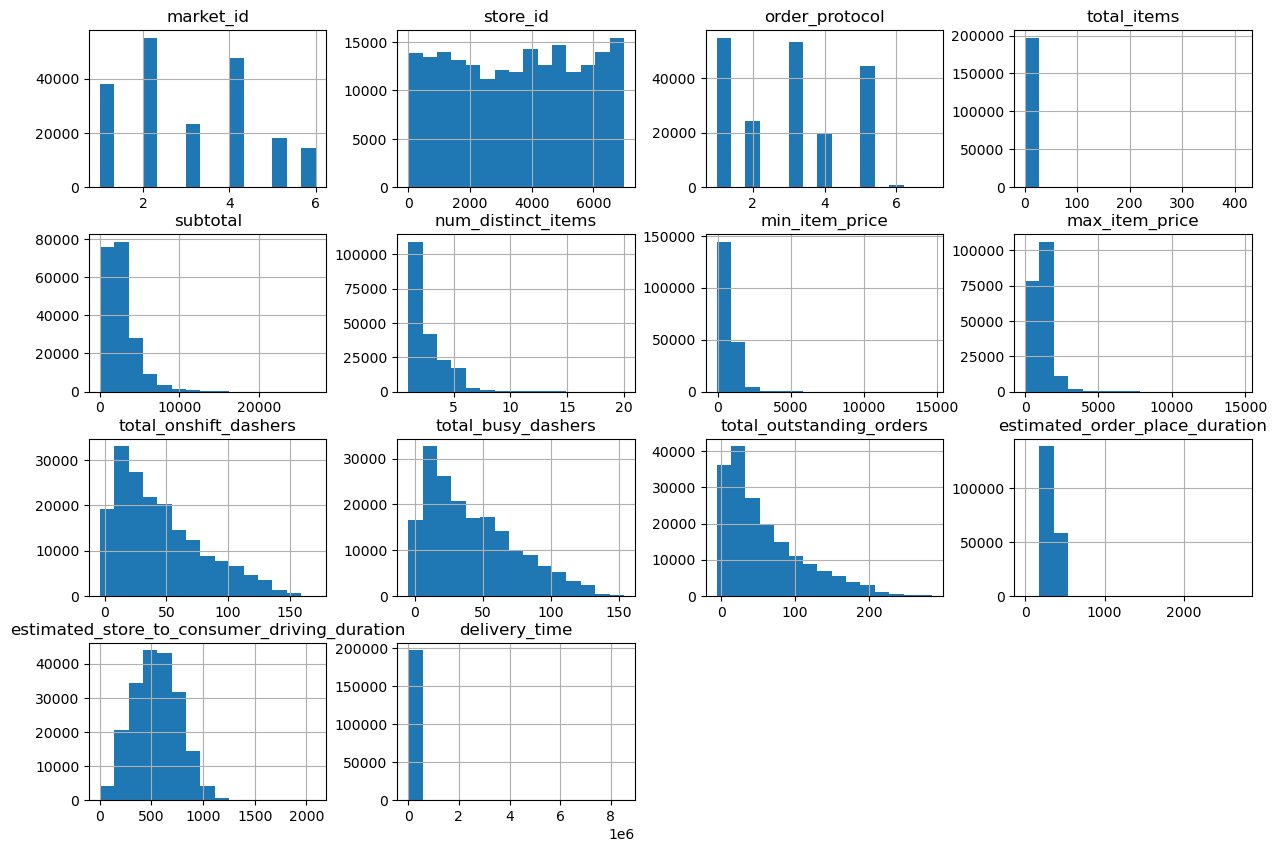

In [162]:
# Handling Missing Data
missing_data = dash.isnull().sum()
missing_percentage = (missing_data / len(dash)) * 100

# Exploratory Data Analysis (EDA)
# Descriptive statistics
descriptive_stats = dash.describe()

# Exclude non-numerical columns for correlation calculation
numerical_dash = dash.select_dtypes(include=['int64', 'float64', 'float32', 'int32'])

# Correlation analysis
correlation_with_target = numerical_dash.corr()['delivery_time'].sort_values()

# Plotting histograms for numerical features
numerical_features = dash.select_dtypes(include=['int64', 'float64']).columns
dash[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 4))

# Displaying missing data statistics and descriptive stats
missing_data, missing_percentage, descriptive_stats, correlation_with_target

In [163]:
# Function to create periodic time features
def create_periodic_time_features(date_series, period='year'):
    x_coordinates = []
    y_coordinates = []
    
    for date in date_series:
        year = date.year

        elif period == 'month':
            passed_days = date.day
            nr_of_days_per_period = calendar.monthrange(year, date.month)[1]
            
        elif period == 'week':
            passed_days = date.weekday() + 1
            nr_of_days_per_period = 7
            
        elif period == 'day':
            passed_days = date.hour * 60 + date.minute
            nr_of_days_per_period = 24 * 60 
            
        else:
            raise ValueError("Invalid period. Choose from 'year', 'month', 'week'.")

        position_within_period = passed_days / nr_of_days_per_period

        # Scale to 2pi
        alpha = position_within_period * math.pi * 2

        # Calculate sin and cos
        period_circle_x = math.sin(alpha)
        period_circle_y = math.cos(alpha)

        # Scale between 0 and 1
        period_circle_x = (period_circle_x + 1) / 2
        period_circle_y = (period_circle_y + 1) / 2

        x_coordinates.append(period_circle_x)
        y_coordinates.append(period_circle_y)
        
    return x_coordinates, y_coordinates

# Applying the function to the dataset
year_x, year_y = create_periodic_time_features(dash['created_at'], period='year')
month_x, month_y = create_periodic_time_features(dash['created_at'], period='month')
week_x, week_y = create_periodic_time_features(dash['created_at'], period='week')

# Adding the new features to the dataframe
dash['Month_Circle_X'] = month_x
dash['Month_Circle_Y'] = month_y
dash['Week_Circle_X'] = week_x
dash['Week_Circle_Y'] = week_y
dash['Day_Circle_X'] = day_x
dash['Day_Circle_Y'] = day_y


# Converting 'created_at' to datetime
day_of_week = data['created_at'].dt.dayofweek  # Monday=0, Sunday=6
data['is_weekend'] = day_of_week.apply(lambda x: 1 if x >= 5 else 0)


# Checking the first few rows of the updated dataframe
dash.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,Month_Circle_X,Month_Circle_Y,Week_Circle_X,Week_Circle_Y
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,33.0,14.0,21.0,446,861.0,3779.0,0.987464,0.611260,0.012536,0.388740
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,1.0,2.0,2.0,446,690.0,4024.0,0.890916,0.188255,0.987464,0.388740
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,1781.0,0.015961,0.374674,0.283058,0.049516
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,3075.0,0.811745,0.890916,0.987464,0.388740
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,2390.0,0.388740,0.012536,0.500000,1.000000


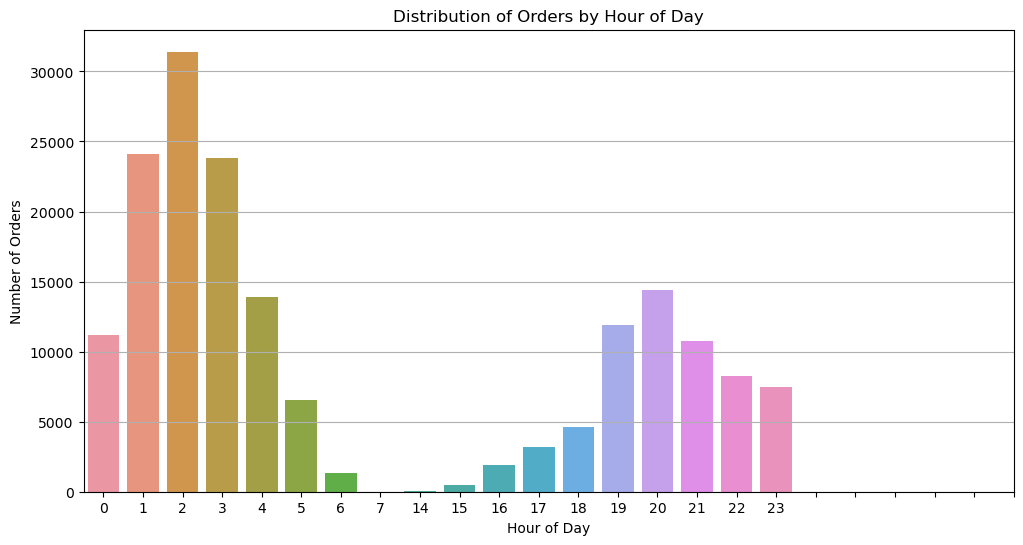

In [176]:
# Extracting the hour of the day from the 'created_at' timestamp
hour_of_day = dash['created_at'].dt.hour

# Counting the number of orders for each hour
order_count_by_hour = hour_of_day.value_counts().sort_index()

# Plotting the distribution of orders throughout the day
plt.figure(figsize=(12, 6))
sns.barplot(x=order_count_by_hour.index, y=order_count_by_hour.values)
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()


The availability of dashers slightly correlates with the delivery time with onshift at 0.04697153327346791 and busy at 0.060641055194763746


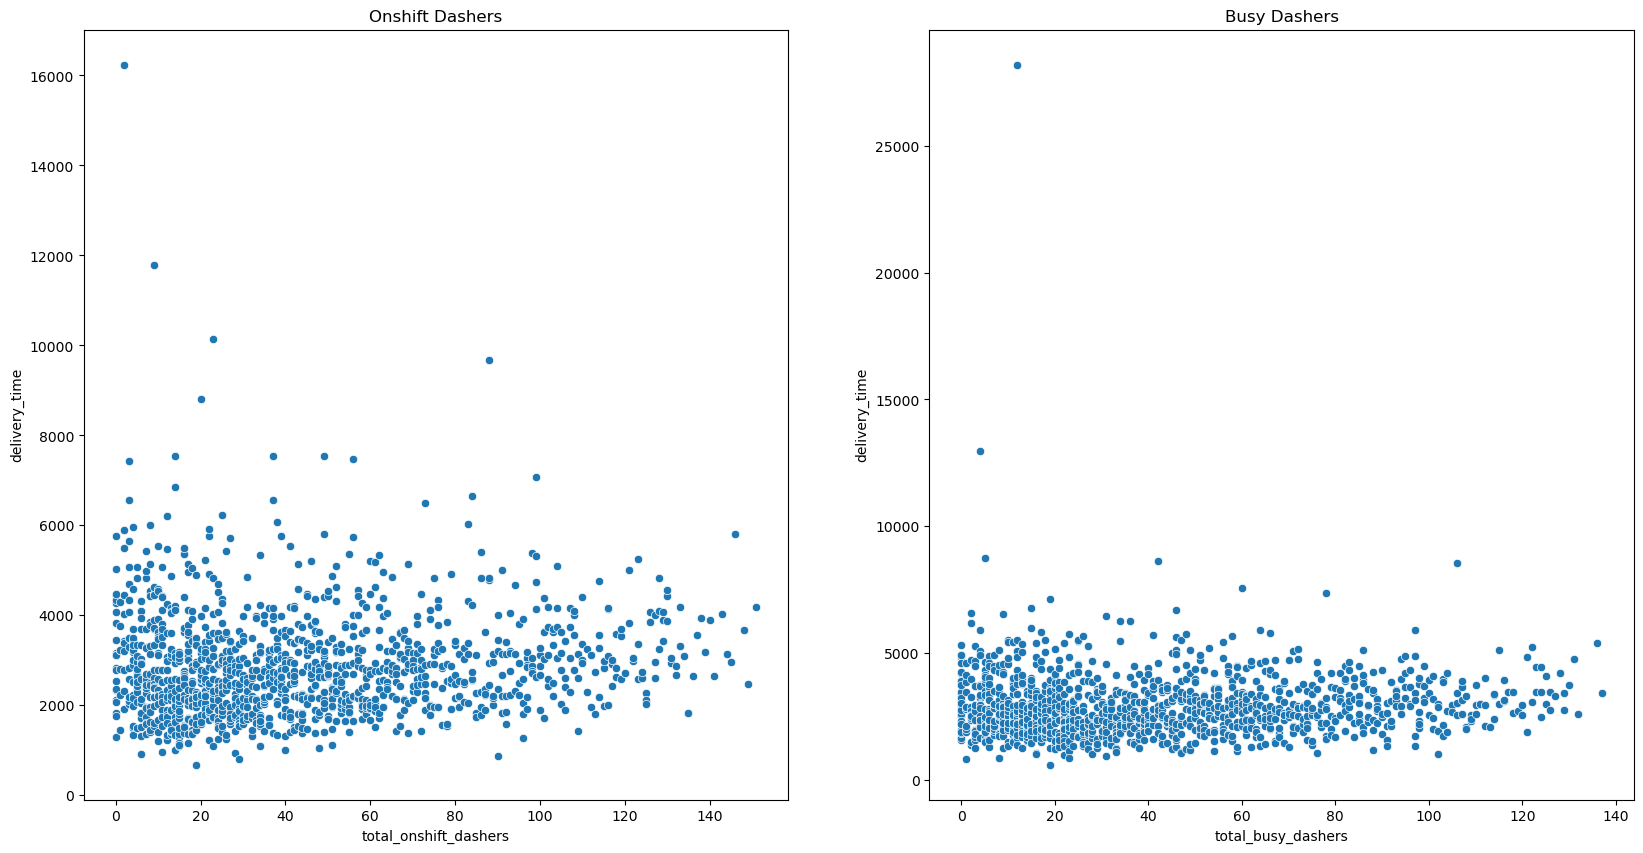

In [164]:
fig, axes = plt.subplots(1, 2,figsize=(20,10))
onshift_dashers = dash.groupby('total_onshift_dashers', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[0],data=onshift_dashers, x="total_onshift_dashers", y="delivery_time")
axes[0].set_title('Onshift Dashers')
 
offshift_dashers = dash.groupby('total_busy_dashers', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[1], data=offshift_dashers, x="total_busy_dashers", y="delivery_time")
axes[1].set_title('Busy Dashers')

print('The availability of dashers slightly correlates with the delivery time with onshift at {} and busy at {}'.format(dash.total_onshift_dashers.corr(dash['delivery_time']),dash.total_busy_dashers.corr(dash['delivery_time'])))

The amount of items seem to differ slightly witha correlation value of 0.004904767615867934 with delivery time as the more items the more time the minimum delviery takes

On the other hand there is little to no relation between min and max item price with 0.004761662013575126 and 0.009409028582511516 respectively



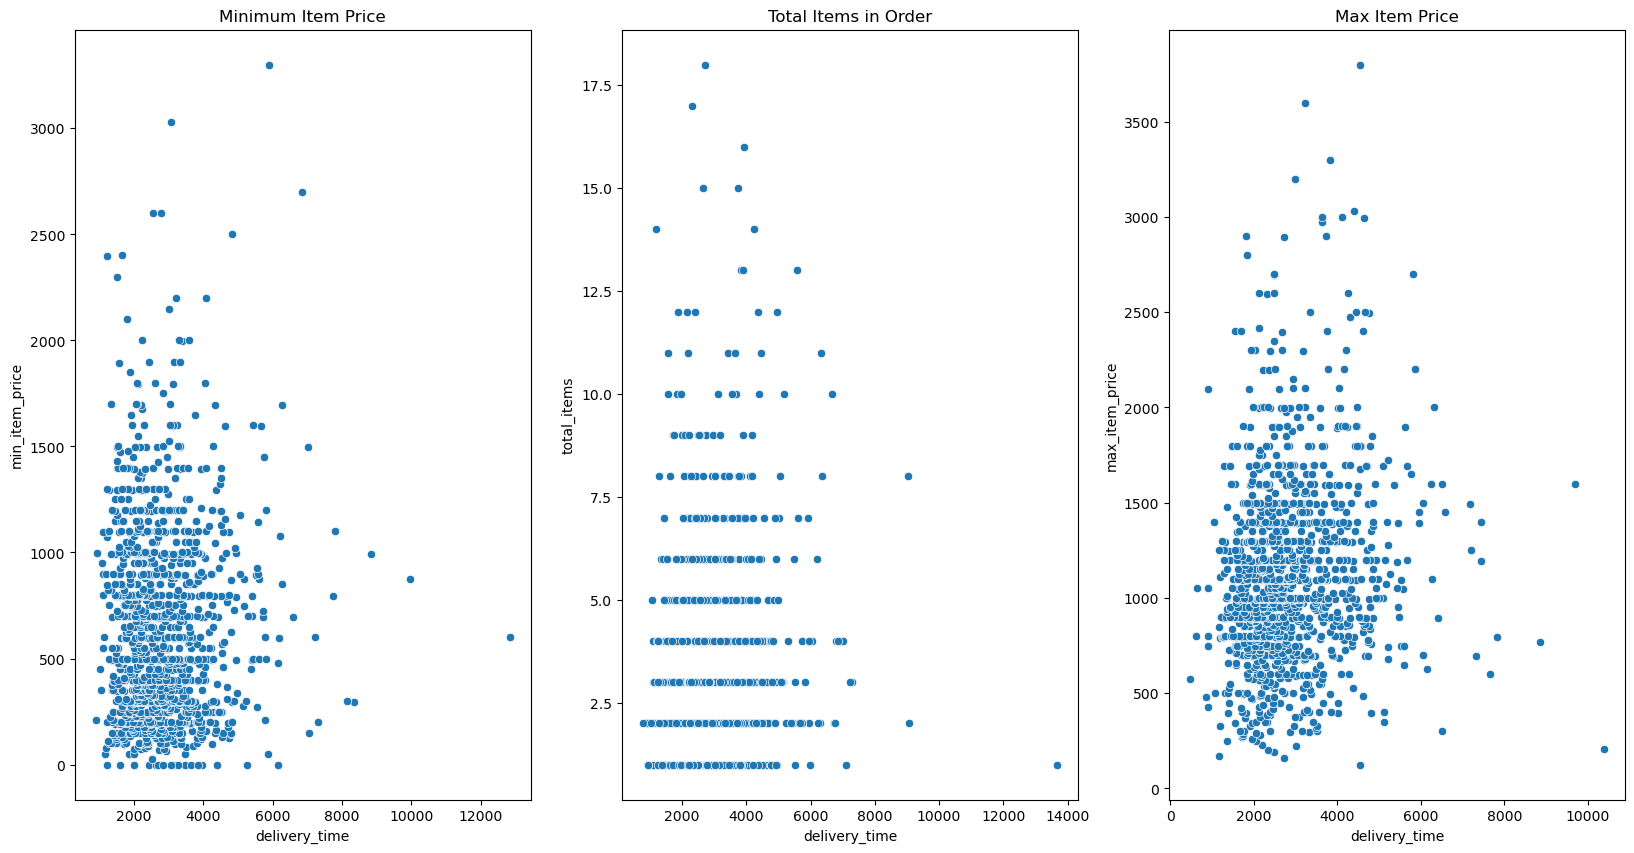

In [165]:
fig, axes = plt.subplots(1, 3,figsize=(20,10))

min_item = dash.groupby('min_item_price', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[0], data=min_item, x="delivery_time", y="min_item_price")
axes[0].set_title('Minimum Item Price')

item_count = dash.groupby('total_items', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[1], data=item_count, x="delivery_time", y="total_items")
axes[1].set_title('Total Items in Order')


max_item = dash.groupby('max_item_price', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[2], data=max_item, x="delivery_time", y="max_item_price")
axes[2].set_title('Max Item Price')

print('The amount of items seem to differ slightly witha correlation value of {} with delivery time as the more items the more time the minimum delviery takes\n'.format(dash.total_items.corr(dash['delivery_time'])))
print('On the other hand there is little to no relation between min and max item price with {} and {} respectively\n'.format(dash.min_item_price.corr(dash['delivery_time']), dash.max_item_price.corr(dash['delivery_time'])))

In [166]:
dash.groupby('store_primary_category').delivery_time.agg(['min','max','mean']).sort_values(by='mean',ascending=True).head(10)

,min,max,mean
store_primary_category,,,
chocolate,2048.0,2048.0,2048.000000
indonesian,2442.0,2448.0,2445.000000
kosher,1250.0,6347.0,2494.568627
gluten-free,1136.0,4949.0,2521.709677
fast,516.0,18809.0,2631.216389
turkish,750.0,6676.0,2666.506329
mexican,101.0,38143.0,2672.812083
smoothie,386.0,22912.0,2681.460518
sandwich,223.0,22737.0,2685.642112


<Axes: xlabel='delivery_time', ylabel='store_primary_category'>

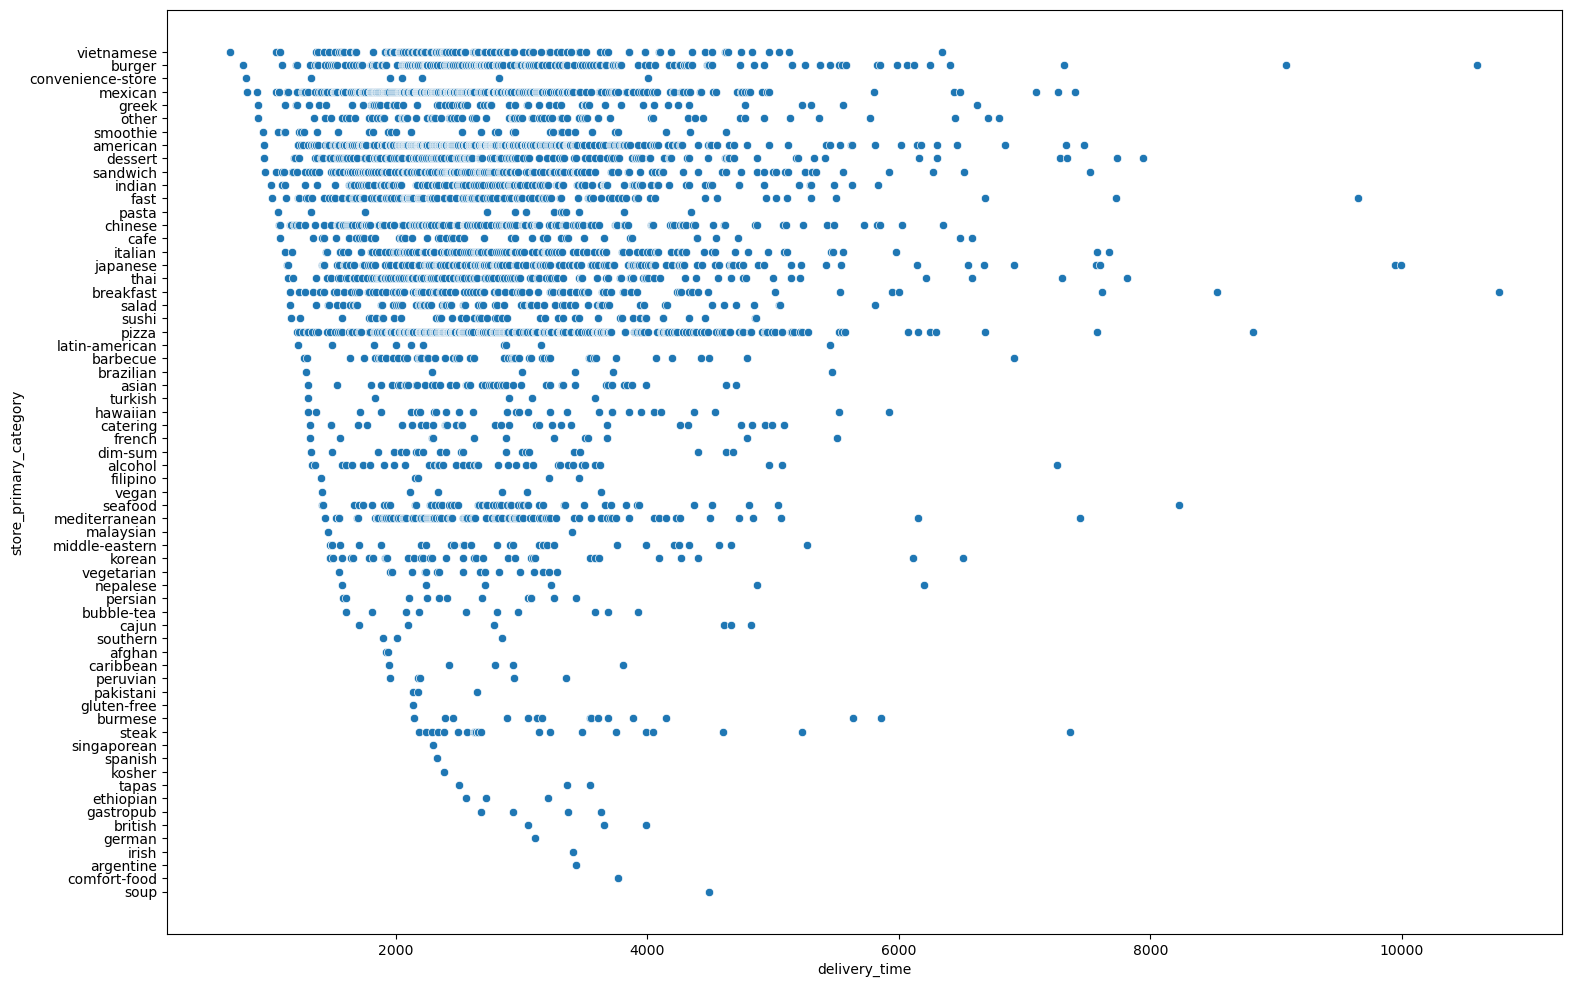

In [167]:
store_cat = dash.groupby('store_primary_category', group_keys=False).apply(lambda x: x.sample(frac=0.02)).sort_values(by='delivery_time')
plt.figure(figsize=(18,12))
sns.scatterplot(data=store_cat, x="delivery_time", y="store_primary_category")

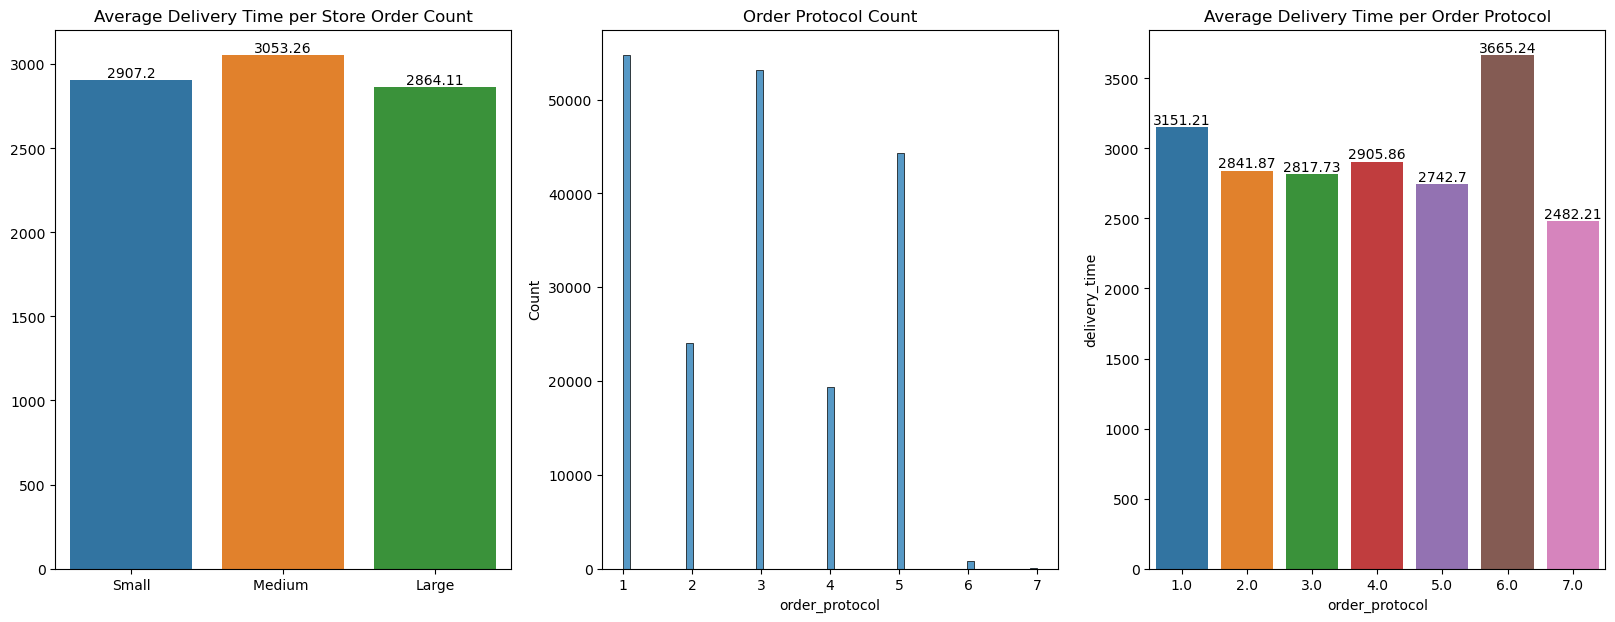

In [171]:
store = dash.groupby(['store_id','store_primary_category']).delivery_time.agg(['min','max','mean','count']).sort_values(by=['count','mean'],ascending=False).reset_index()

fig, axes = plt.subplots(1, 3,figsize=(20,7))
small = store.loc[store['count']<10]['mean'].mean()
mid = store.loc[(store['count']>10) & (store['count']<400)]['mean'].mean()
large = store.loc[store['count']>400]['mean'].mean()

graph1=sns.barplot(ax=axes[0], x=["Small","Medium ","Large"], y=[small,mid,large])
axes[0].set_title('Average Delivery Time per Store Order Count')
axes[0].ylabel='Average Delivery Time'
axes[0].xlabel='Store order Count'
graph1.bar_label(axes[0].containers[-1])

graph2 = sns.histplot(data=dash, x="order_protocol",ax=axes[1])
axes[1].set_title('Order Protocol Count')


order_proto = dash.groupby('order_protocol').delivery_time.mean().reset_index()
graph=sns.barplot(ax=axes[2],data=order_proto,x='order_protocol', y='delivery_time')
axes[2].set_title('Average Delivery Time per Order Protocol')
for i in graph.containers:
    axes[2].bar_label(i,)

In [172]:
# Handling Missing Data
# Imputing missing values for columns with lower percentages of missing data
# For higher percentages, more investigation is needed to decide

# Imputing with median for numerical columns
for col in ['market_id', 'order_protocol', 'total_onshift_dashers', 
            'total_busy_dashers', 'total_outstanding_orders', 
            'estimated_store_to_consumer_driving_duration']:
    if dash[col].isnull().sum() / len(dash) < 0.1:  # Less than 10% missing
        dash[col].fillna(dash[col].median(), inplace=True)

# For categorical columns, imputing with the mode (most frequent category)
dash['store_primary_category'].fillna(dash['store_primary_category'].mode()[0], inplace=True)

# Dropping rows where 'actual_delivery_time' is missing
dash.dropna(subset=['actual_delivery_time'], inplace=True)

# Outlier Detection and Handling
# Using IQR method for columns that are skewed
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

# Removing outliers from 'total_items', 'subtotal', and 'delivery_time'
for col in ['total_items', 'subtotal', 'delivery_time']:
    dash = remove_outliers(dash, col)

# Checking the dataset after handling missing data and outliers
dash.info(), dash.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 175410 entries, 0 to 197427
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175410 non-null  float64       
 1   created_at                                    175410 non-null  datetime64[ns]
 2   actual_delivery_time                          175410 non-null  datetime64[ns]
 3   store_id                                      175410 non-null  int64         
 4   store_primary_category                        175410 non-null  object        
 5   order_protocol                                175410 non-null  float64       
 6   total_items                                   175410 non-null  int64         
 7   subtotal                                      175410 non-null  int64         
 8   num_distinct_items                            175410 non-nu

(None,
            market_id                     created_at  \
 count  175410.000000                         175410   
 mean        2.994037  2015-02-04 21:55:20.176381184   
 min         1.000000            2015-01-21 15:22:03   
 25%         2.000000            2015-01-29 02:03:25   
 50%         3.000000            2015-02-05 04:30:28   
 75%         4.000000  2015-02-12 01:30:57.750000128   
 max         6.000000            2015-02-18 06:00:44   
 std         1.518185                            NaN   
 
                 actual_delivery_time       store_id  order_protocol  \
 count                         175410  175410.000000   175410.000000   
 mean   2015-02-04 22:40:20.199190272    3536.858862        2.887036   
 min              2015-01-21 15:58:11       1.000000        1.000000   
 25%              2015-01-29 02:49:42    1686.000000        1.000000   
 50%              2015-02-05 05:32:29    3597.000000        3.000000   
 75%    2015-02-12 02:12:55.750000128    5301.000000   

In [173]:
# Using One-Hot Encoding for 'store_primary_category'
encoder = OneHotEncoder(sparse=False)
store_category_encoded = encoder.fit_transform(dash[['store_primary_category']])

# Creating a DataFrame from the encoded categories
store_category_df = pd.DataFrame(
    store_category_encoded, 
    columns=encoder.get_feature_names_out(['store_primary_category']),
    index=dash.index
)

# Merging the new features with the original dataframe
dash = pd.concat([dash, store_category_df], axis=1)

# Dropping the original 'store_primary_category' column
dash.drop('store_primary_category', axis=1, inplace=True)

# Data Preparation for Modeling
# Normalizing numerical features
numerical_cols = dash.select_dtypes(include=['int64', 'float64']).columns
dash[numerical_cols] = StandardScaler().fit_transform(dash[numerical_cols])

# Separating the features (X) and the target variable (y)
y = dash['delivery_time']
X = dash.drop(['delivery_time', 'created_at', 'actual_delivery_time'], axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Checking the transformed dataset
X_train.head(), X_train.shape, X_test.shape



/Users/benasadi/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(        market_id  store_id  order_protocol  total_items  subtotal  \
 138167   1.979977  1.200434       -1.255083     0.875715  0.478857   
 105622   0.003928  1.611265       -1.255083    -0.479473  0.028428   
 67965    1.979977 -0.418064        1.405349     0.198121 -0.052502   
 63954   -0.654755  1.569890        1.405349    -0.479473 -0.763706   
 170400  -0.654755  1.423373        0.075133    -0.479473  0.465778   
 
         num_distinct_items  min_item_price  max_item_price  \
 138167            1.282872       -0.834968        0.040422   
 105622           -0.318100       -0.658020       -0.060921   
 67965             0.482386       -0.795646        0.527267   
 63954            -0.318100       -0.785816       -0.068870   
 170400           -0.318100        1.276614        0.537202   
 
         total_onshift_dashers  total_busy_dashers  ...  \
 138167              -0.211824           -0.225115  ...   
 105622              -1.000030           -0.973484  ...   
 67965         

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Since we have already normalized the numerical features and created encoded features, 
# we will prepare the dataset by excluding the original date columns and the target variable
X = dash.drop(['created_at', 'actual_delivery_time', 'delivery_time'], axis=1)
y = dash['delivery_time']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model Building: Linear Regression
# Initializing the Linear Regression model
lr_model = LinearRegression()

# Fitting the model to the training data
lr_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = lr_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2



(0.7647277380974611, 0.23403378794800112)